참조:https://qiskit.org/textbook/ch-demos/chsh.html
q0= Alice
q1=Charile
q2,q3=Bob
1. Alice와 Bob entanglement
2. Charile 와 Bob entanglement
3. Bob 이 Bell state 측정 (Entanglement swapping),(코드에서는 Bob의 측정 결과 중 (|00>+|11>)/√2만 사용했어요.)
4. Alice와 Bob이 가진 큐빗에 대해서 CHSH-3 측정

In [1]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise
import numpy as np
#import python stuff
import matplotlib.pyplot as plt
import numpy as np

In [2]:
if not IBMQ.active_account():
    IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')

In [3]:
from qiskit.providers.aer import AerSimulator
sim = AerSimulator.from_backend(quito)
# sim = Aer.get_backend('aer_simulator')

In [4]:
def make_chsh_circuit(theta_vec, meas):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        q1 = QuantumRegister(size=1, name='alice')
        q3 = QuantumRegister(size=1, name='charlie')
        q2 = QuantumRegister(size=2, name='bob')
        cr = ClassicalRegister(size=4)
        for el in obs_vec:
            qc = QuantumCircuit(q1, q3, q2, cr)
            qc.h(0)
            qc.h(1)
            qc.cx(0,2)
            qc.cx(1,3)
            qc.cx(2,3)
            qc.h(2)
            qc.measure(2,2)
            qc.measure(3,3)
            qc.barrier()            
            if meas=='ZX':
                qc.ry(theta, 0)
                qc.h(0)
                for i in range(2):
                    if el[i] == '1':
                        qc.h(i)
            elif meas=='ZY':
                
                qc.rx(theta, 0)
                for i in range(2):
                    if el[i] == '1':
                        qc.rx((np.pi)/2,i) 
                        qc.z(i)
            elif meas=='XY':
                qc.rz(-theta, 0)

                for i in range(2):
                    if el[i] == '1':
                        qc.y(i)
                        qc.rz((-np.pi)/2,i)
                qc.h(0)
                qc.h(1)
            else:
                pass

            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits
     
def make_chsh_circuit_ZX(theta_vec):
    return make_chsh_circuit(theta_vec=theta_vec, meas='ZX')

def make_chsh_circuit_ZY(theta_vec):
    return make_chsh_circuit(theta_vec=theta_vec, meas='ZY')

def make_chsh_circuit_XY(theta_vec):
    return make_chsh_circuit(theta_vec=theta_vec, meas='XY')

In [5]:
def compute_chsh_witness(counts, meas):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    CHSH = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh = 0

        if meas=='ZX':
            for element in zz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh-= parity*zz[element]

            for element in zx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zx[element]

            for element in xz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*xz[element]

            for element in xx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*xx[element]
        
        elif meas=='ZY':
            for element in zz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zz[element]

            for element in zx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zx[element]

            for element in xz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*xz[element]

            for element in xx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh-= parity*xx[element]

        elif meas=='XY':
            for element in zz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zz[element]

            for element in zx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*zx[element]

            for element in xz:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh+= parity*xz[element]

            for element in xx:
                parity = (-1)**(int(element[2])+int(element[3]))

                chsh-= parity*xx[element]

        CHSH.append(chsh/no_shots)

    return CHSH

def compute_chsh_witnessZX(counts):
    return compute_chsh_witness(counts=counts, meas='ZX')

def compute_chsh_witnessZY(counts):
    return compute_chsh_witness(counts=counts, meas='ZY')

def compute_chsh_witnessXY(counts):
    return compute_chsh_witness(counts=counts, meas='XY')

In [6]:
number_of_thetas = 15
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuitsZX = make_chsh_circuit_ZX(theta_vec)
my_chsh_circuitsZY = make_chsh_circuit_ZY(theta_vec)
my_chsh_circuitsXY = make_chsh_circuit_XY(theta_vec)

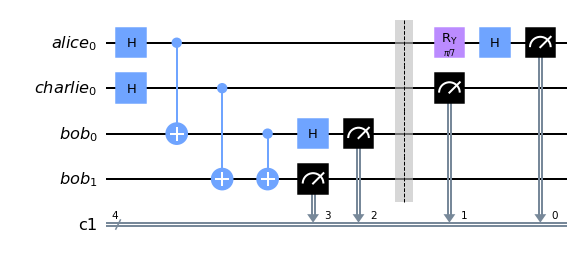

In [7]:
my_chsh_circuitsZX[4].draw(output='mpl')

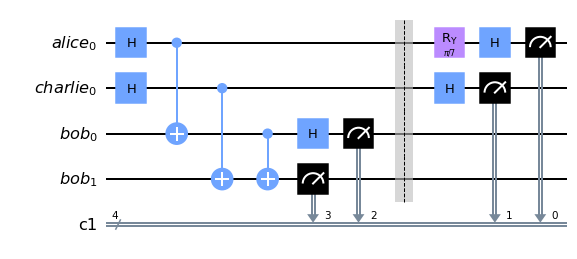

In [8]:
my_chsh_circuitsZX[5].draw(output='mpl')

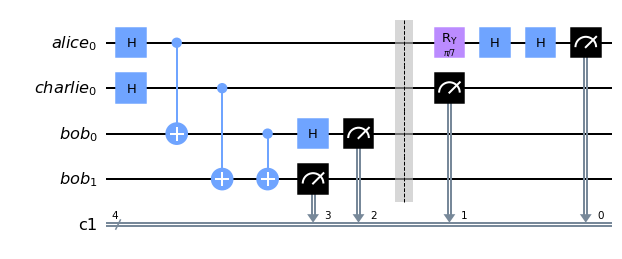

In [9]:
my_chsh_circuitsZX[6].draw(output='mpl')

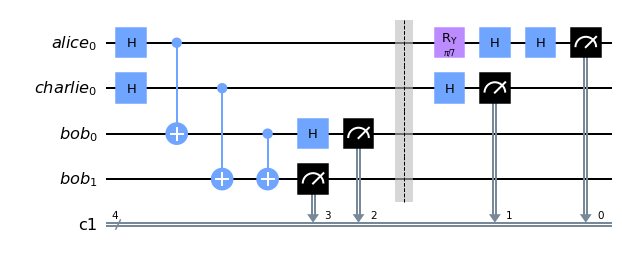

In [10]:
my_chsh_circuitsZX[7].draw(output='mpl')

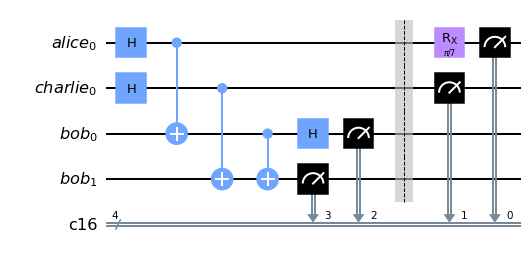

In [11]:
my_chsh_circuitsZY[4].draw(output='mpl')

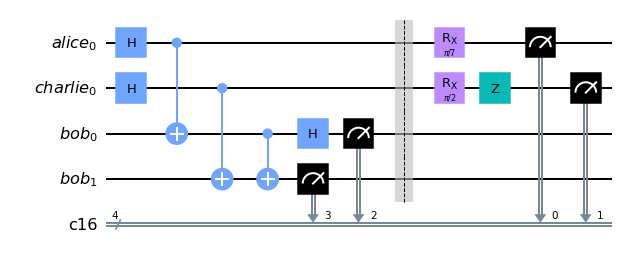

In [12]:
my_chsh_circuitsZY[5].draw(output='mpl')

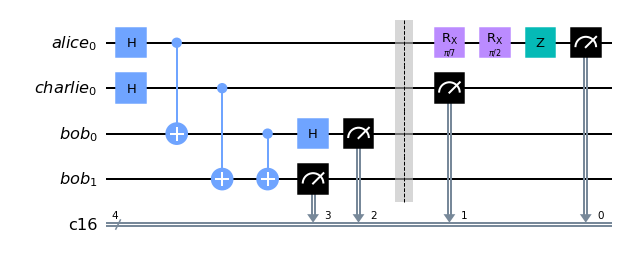

In [13]:
my_chsh_circuitsZY[6].draw(output='mpl')

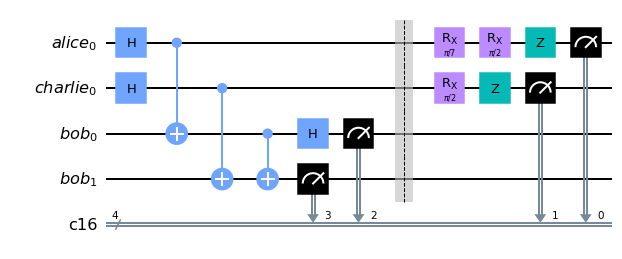

In [14]:
my_chsh_circuitsZY[7].draw(output='mpl')

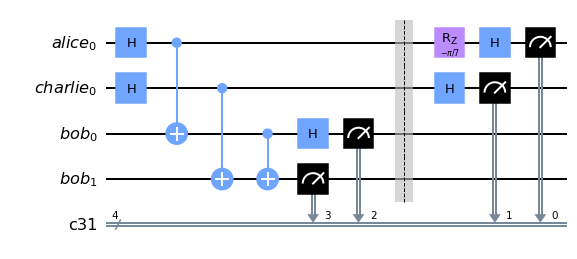

In [15]:
my_chsh_circuitsXY[4].draw(output='mpl')

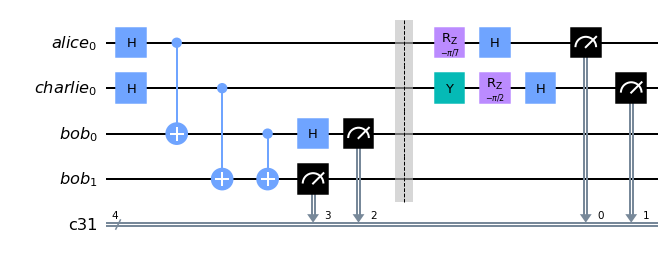

In [16]:
my_chsh_circuitsXY[5].draw(output='mpl')

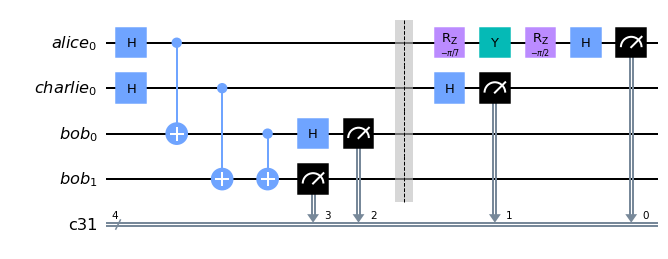

In [17]:
my_chsh_circuitsXY[6].draw(output='mpl')

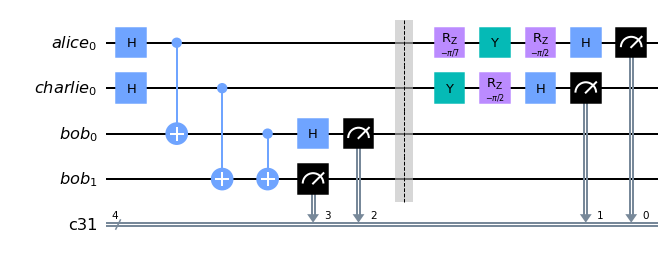

In [18]:
my_chsh_circuitsXY[7].draw(output='mpl')

In [19]:
from qiskit.tools.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
quantum_instance = QuantumInstance(backend=sim, shots=2**13, optimization_level=2)
# Execute and get counts
result_idealZX = quantum_instance.execute(my_chsh_circuitsZX)
result_idealZY = quantum_instance.execute(my_chsh_circuitsZY)
result_idealXY = quantum_instance.execute(my_chsh_circuitsXY)
result_idealZX_ls=result_idealZX.get_counts()
result_idealZY_ls=result_idealZY.get_counts()
result_idealXY_ls=result_idealXY.get_counts()

In [20]:
# Bob's meausrement = (|00>+|11>)/√2 만 사용하기 위해 다른 건 삭제했어요.
# Bob의 상태가(|00>+|11>)/√2 일 때 측정하면|00**>상태로 나와요.

for item in result_idealZX_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_idealZY_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)
for item in result_idealXY_ls:
    item.pop('0100',None)
    item.pop('0101',None)
    item.pop('0110',None)
    item.pop('0111',None)
    item.pop('1000',None)
    item.pop('1001',None)
    item.pop('1010',None)
    item.pop('1011',None)
    item.pop('1100',None)
    item.pop('1101',None)
    item.pop('1110',None)
    item.pop('1111',None)

In [21]:
CHSHZX_ideal = compute_chsh_witnessZX(result_idealZX_ls)
CHSHZY_ideal = compute_chsh_witnessZY(result_idealZY_ls)
CHSHXY_ideal = compute_chsh_witnessXY(result_idealXY_ls)

Text(0, 0.5, 'CHSH witness')

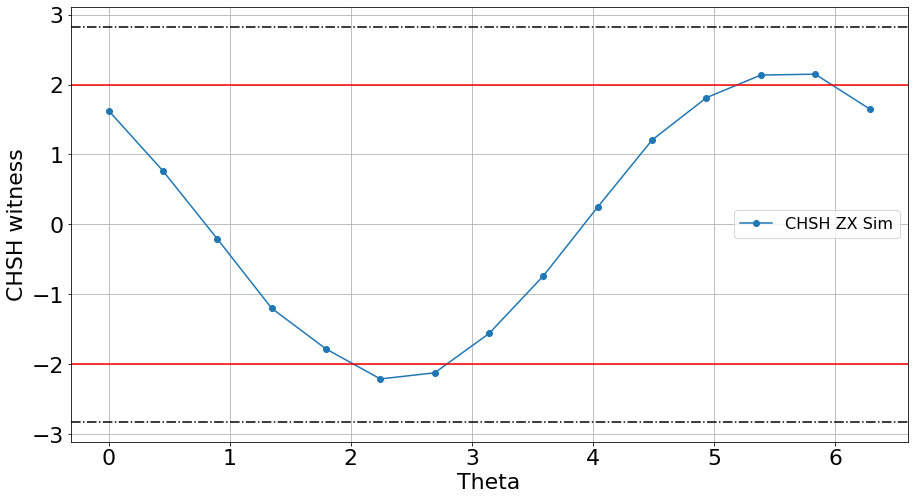

In [22]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta_vec,CHSHZX_ideal,'o-',label = 'CHSH ZX Sim')


plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

Text(0, 0.5, 'CHSH witness')

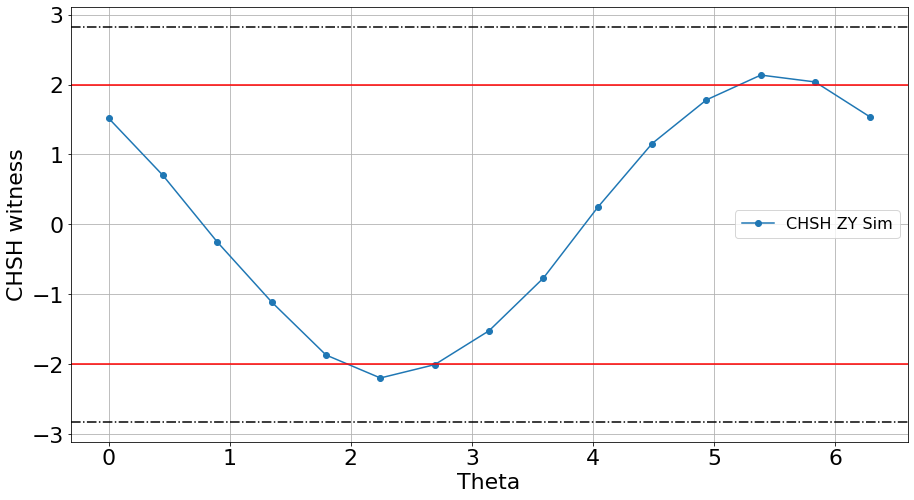

In [23]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta_vec,CHSHZY_ideal,'o-',label = 'CHSH ZY Sim')


plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

Text(0, 0.5, 'CHSH witness')

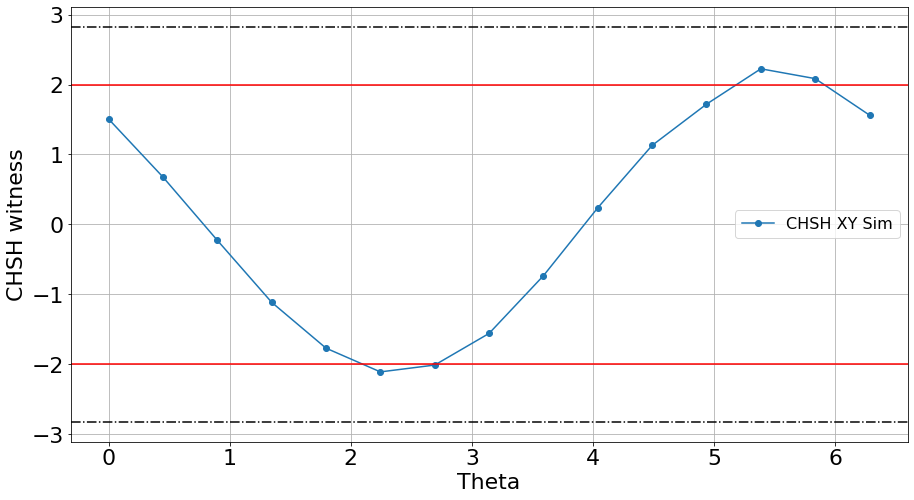

In [24]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta_vec,CHSHXY_ideal,'o-',label = 'CHSH XY Sim')


plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

Text(0, 0.5, 'CHSH witness')

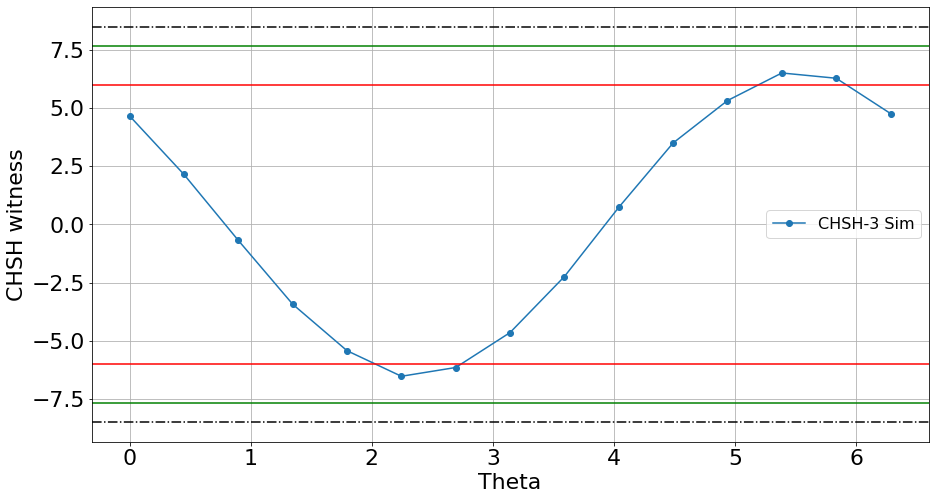

In [25]:
CHSH3_ideal=[0 for i in range(number_of_thetas)]
for i in range(number_of_thetas):
    CHSH3_ideal[i]=CHSHZX_ideal[i]+CHSHZY_ideal[i]+CHSHXY_ideal[i]
    
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta_vec,CHSH3_ideal,'o-',label = 'CHSH-3 Sim')


plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=6, color='r', linestyle='-')
plt.axhline(y=-6, color='r', linestyle='-')
plt.axhline(y=7.66, color='g', linestyle='-')
plt.axhline(y=-7.66, color='g', linestyle='-')

plt.axhline(y=np.sqrt(2)*6, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*6, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')